In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/XTissueImmuneAtlas


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                         10.0.0
anndata                     0.9.2
anyio                       NA
arrow                       1.2.3
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.12.1
backcall                    0.2.0
brotli                      1.1.0
certifi                     2023.07.22
cffi                        1.15.1
charset_normalizer          3.2.0
cloudpickle                 2.2.1
cnmf                        NA
colorama                    0.4.6
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dask                        2023.5.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.1.3
executing                   1.2.0
fastcluster                 1.2.6
fastjsonschema

# Parameters

In [4]:
! ls ../../../Data/PerDataset/XTissueImmuneAtlas

T.counts.h5ad
T.counts.NoBlood.20230927RNA.HVGlist.tsv
T.counts.NoBlood.20230927RNA.TP10K.h5ad
T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad
T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.WithUMAP.h5ad
T.counts.WithBlood.20230927RNA.HVGlist.tsv
T.counts.WithBlood.20230927RNA.TP10K.h5ad
T.counts.WithBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad
T.counts.WithBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.WithUMAP.h5ad
XTissue.20230927.NoBlood
XTissue.20230927.NoBlood.Iter200
XTissue.20230927.NoBlood.Iter200.Spectra_Scores.Relabeled.tsv
XTissue.20230927.NoBlood.Iter200.Spectra_TPM.Relabeled.tsv
XTissue.20230927.NoBlood.Iter200.Usage.Relabeled.tsv
XTissue.20230927.WithBlood


# Run pipeline for non-blood tissues

In [4]:
params = {
'harmony_vars' : ['Organ', 'Donor', 'Chemistry'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : None,
'adt_feature_name' : None,
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 31,
'n_adt_pcs' : 21,
'name_addition' : '.NoBlood.20230927', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927FiltForcNMF.h5ad',
 'TP10K': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.TP10K.h5ad'}

In [5]:
adata = sc.read(paths['Original'])

In [7]:
adata.obs['Organ'].value_counts()

LLN       41630
SPL       27592
JEJEPI    23221
BMA       18978
JEJLP     15440
BLD       15314
MLN       14934
LIV        5176
LNG        4936
ILE         619
DUO         450
SKM         396
OME         320
THY         255
CAE         181
TCL         120
SCL          66
Name: Organ, dtype: int64

In [8]:
adata.shape

(169628, 24046)

In [9]:
15314 / 169628

0.09027990661919023

In [10]:
adata = adata[adata.obs['Organ']!='BLD', :]

In [15]:
adata.obs['SampleID'] = adata.obs['Donor'].astype(str) + '.' + adata.obs['Organ'].astype(str)

/tmp/ipykernel_8328/1843062498.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['SampleID'] = adata.obs['Donor'].astype(str) + '.' + adata.obs['Organ'].astype(str)


In [16]:
adata

AnnData object with n_obs × n_vars = 154314 × 24046
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range', 'pct_mito', 'SampleID'
    var: 'gene'
    obsm: 'X_umap'

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


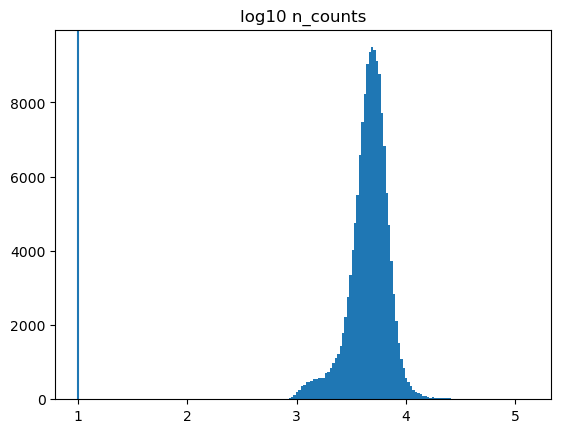

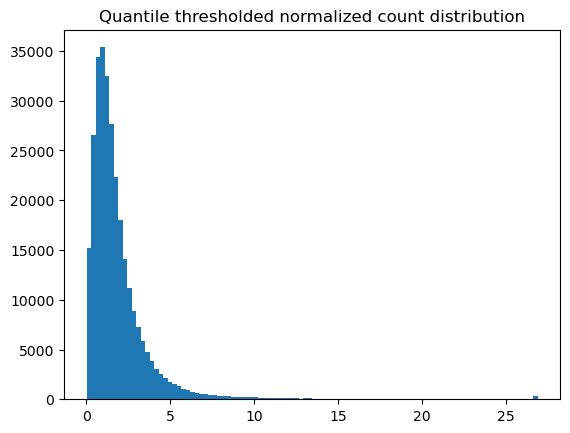

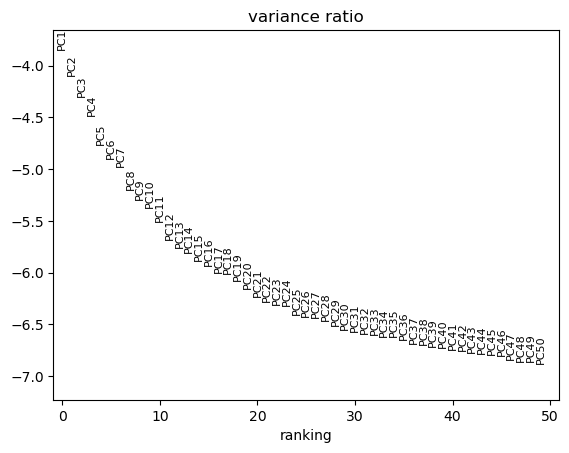

2023-10-09 13:51:01,426 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-09 13:51:52,906 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-09 13:51:54,698 - harmonypy - INFO - Iteration 1 of 20
2023-10-09 13:54:09,951 - harmonypy - INFO - Iteration 2 of 20
2023-10-09 13:56:32,662 - harmonypy - INFO - Iteration 3 of 20
2023-10-09 13:59:00,395 - harmonypy - INFO - Iteration 4 of 20
2023-10-09 14:01:10,632 - harmonypy - INFO - Iteration 5 of 20
2023-10-09 14:03:17,332 - harmonypy - INFO - Iteration 6 of 20
2023-10-09 14:04:53,928 - harmonypy - INFO - Iteration 7 of 20
2023-10-09 14:06:18,145 - harmonypy - INFO - Iteration 8 of 20
2023-10-09 14:07:29,447 - harmonypy - INFO - Iteration 9 of 20
2023-10-09 14:08:44,456 - harmonypy - INFO - Iteration 10 of 20
2023-10-09 14:09:46,457 - harmonypy - INFO - Iteration 11 of 20
2023-10-09 14:10:54,882 - harmonypy - INFO - Iteration 12 of 20
2023-10-09 14:11:54,975 - harmonypy - INFO - Iteration 13 of

In [17]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata_RNA, harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [18]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [21]:
adata_RNA_c

AnnData object with n_obs × n_vars = 154314 × 2000
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range', 'pct_mito', 'SampleID', 'n_counts'
    var: 'gene', 'features_renamed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'X_umap', 'X_pca', 'X_pca_harmony'

In [20]:
import os
os.path.abspath(paths['Metadata'])

'/data/srlab1/TCAT/Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927metadata.tsv'

In [12]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [13]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

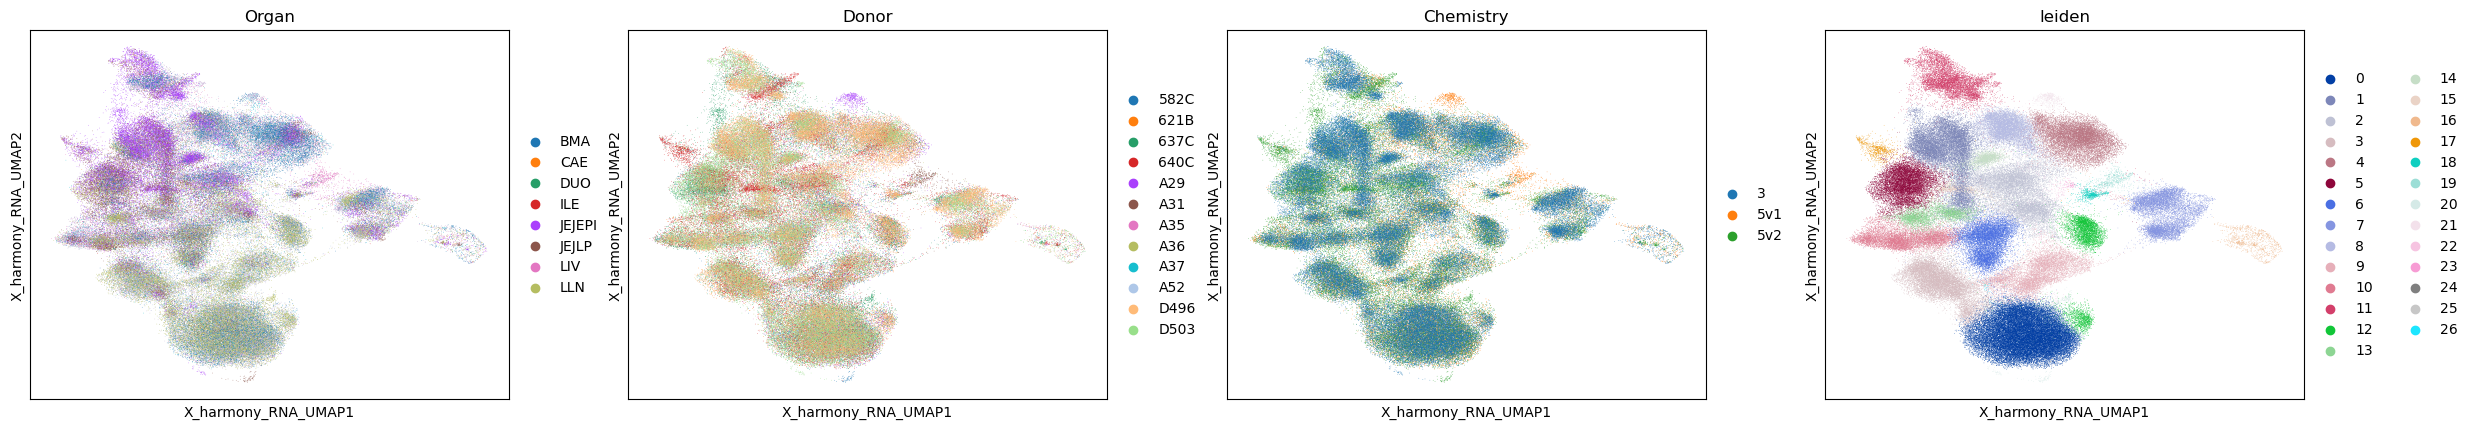

In [14]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

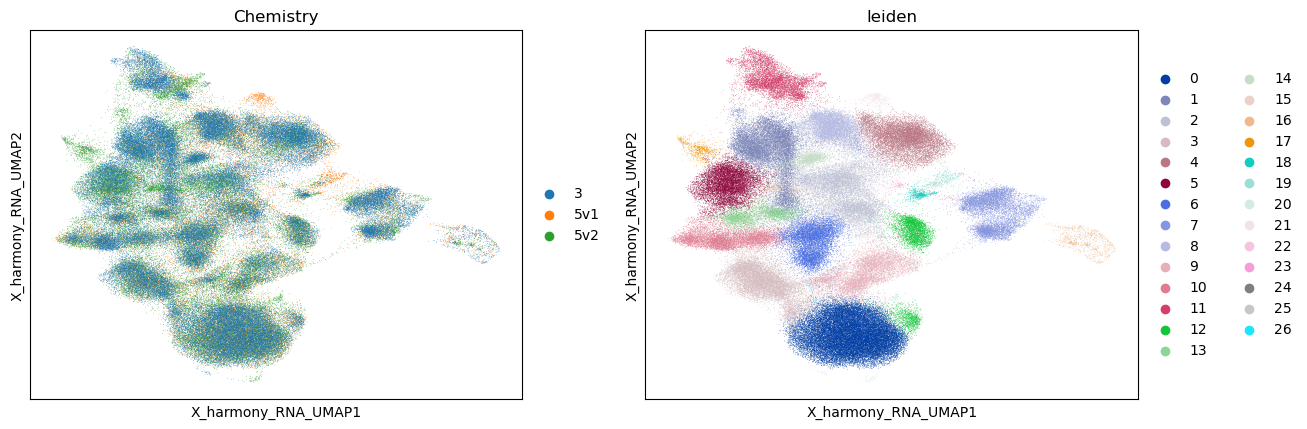

In [17]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= ['Chemistry', 'leiden'])

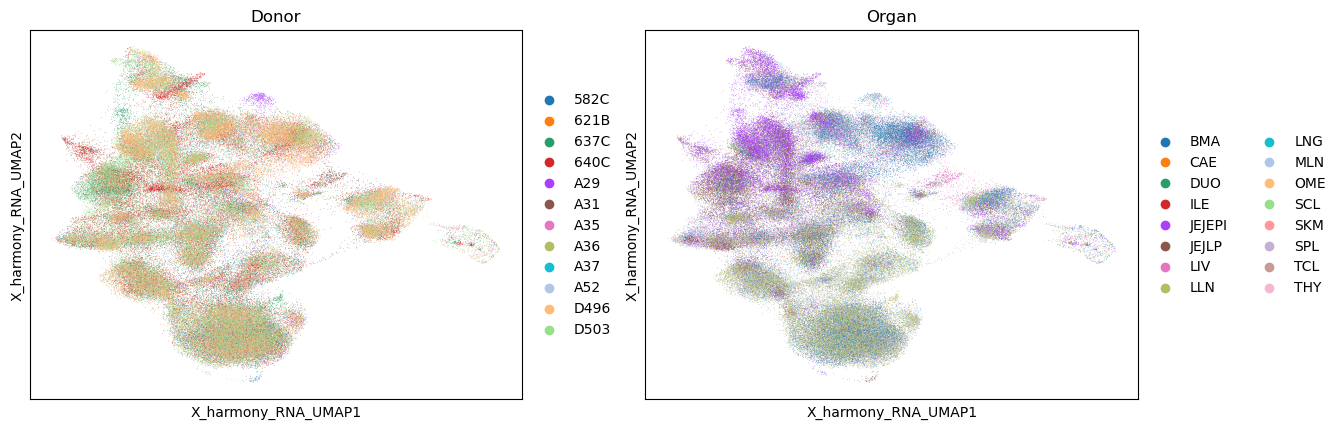

In [16]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= ['Donor', 'Organ'])

In [18]:
paths['RNA_Varnorm_Harmony']

'../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [20]:
sc.write(paths['RNA_Varnorm_Harmony'].replace('.h5ad', '.WithUMAP.h5ad'), adata_RNA_c)


Only considering the two last: ['.WithUMAP', '.h5ad'].
Only considering the two last: ['.WithUMAP', '.h5ad'].


In [6]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [7]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((169628, 24046), (154314, 2000), (154314, 24046))

In [8]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927FiltForcNMF.h5ad'

In [9]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].
Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].


# Run pipeline for all tissues including blood

In [21]:
params = {
'harmony_vars' : ['Organ', 'Donor', 'Chemistry'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : None,
'adt_feature_name' : None,
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 31,
'n_adt_pcs' : 21,
'name_addition' : '.WithBlood.20230927', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.WithBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.WithBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.WithBlood.20230927metadata.tsv',
 'TP10K': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.WithBlood.20230927RNA.TP10K.h5ad'}

In [22]:
adata = sc.read(paths['Original'])

In [23]:
adata.obs['Organ'].value_counts()

LLN       41630
SPL       27592
JEJEPI    23221
BMA       18978
JEJLP     15440
BLD       15314
MLN       14934
LIV        5176
LNG        4936
ILE         619
DUO         450
SKM         396
OME         320
THY         255
CAE         181
TCL         120
SCL          66
Name: Organ, dtype: int64

In [24]:
adata.shape

(169628, 24046)

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


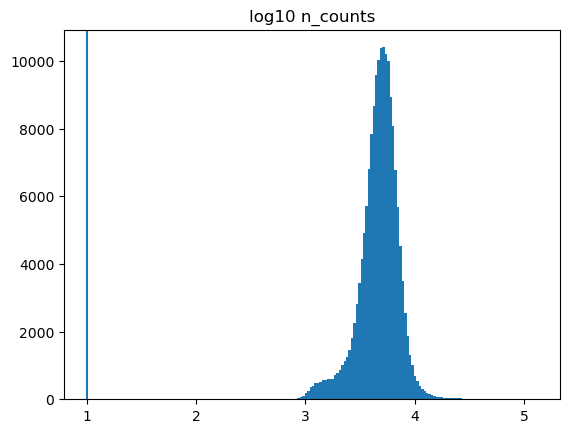

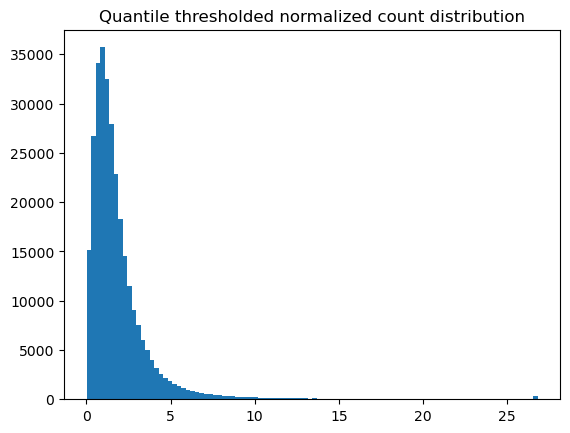

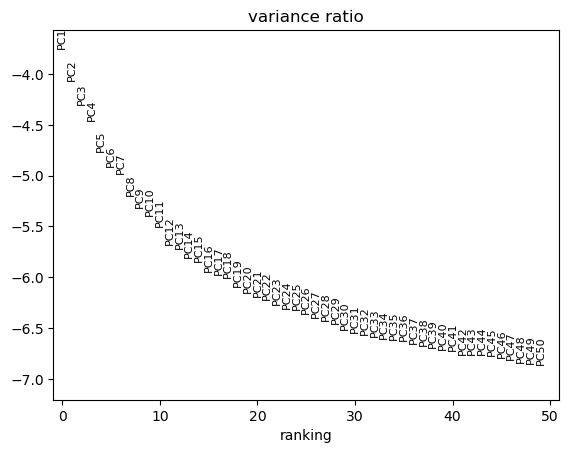

2023-09-27 18:17:51,111 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-27 18:18:28,603 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-27 18:18:30,300 - harmonypy - INFO - Iteration 1 of 20
2023-09-27 18:20:12,348 - harmonypy - INFO - Iteration 2 of 20
2023-09-27 18:21:54,188 - harmonypy - INFO - Iteration 3 of 20
2023-09-27 18:23:35,665 - harmonypy - INFO - Iteration 4 of 20
2023-09-27 18:25:17,398 - harmonypy - INFO - Iteration 5 of 20
2023-09-27 18:26:47,382 - harmonypy - INFO - Iteration 6 of 20
2023-09-27 18:28:28,886 - harmonypy - INFO - Iteration 7 of 20
2023-09-27 18:29:46,100 - harmonypy - INFO - Iteration 8 of 20
2023-09-27 18:30:52,568 - harmonypy - INFO - Iteration 9 of 20
2023-09-27 18:32:00,263 - harmonypy - INFO - Iteration 10 of 20
2023-09-27 18:32:57,846 - harmonypy - INFO - Iteration 11 of 20
2023-09-27 18:33:55,806 - harmonypy - INFO - Converged after 11 iterations


In [25]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata_RNA, harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [26]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [27]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

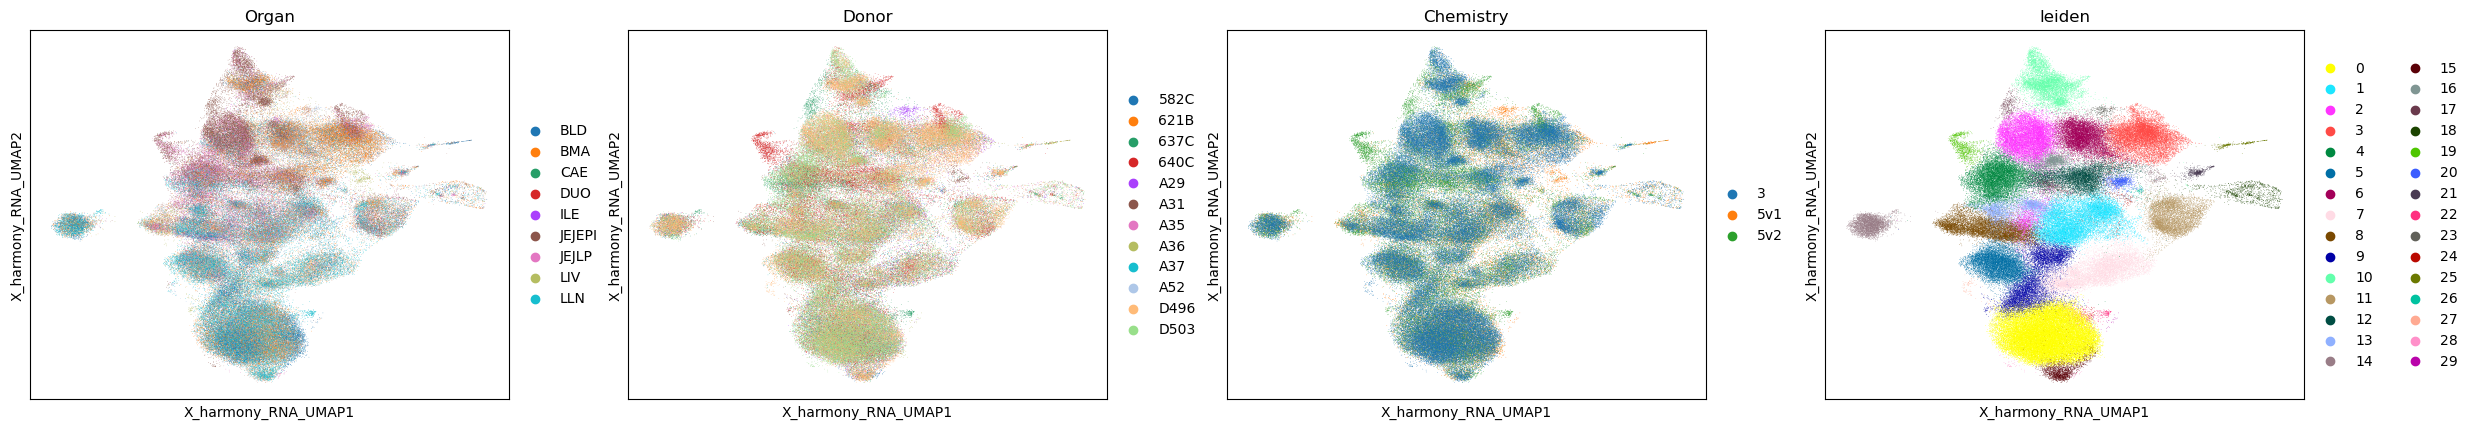

In [28]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

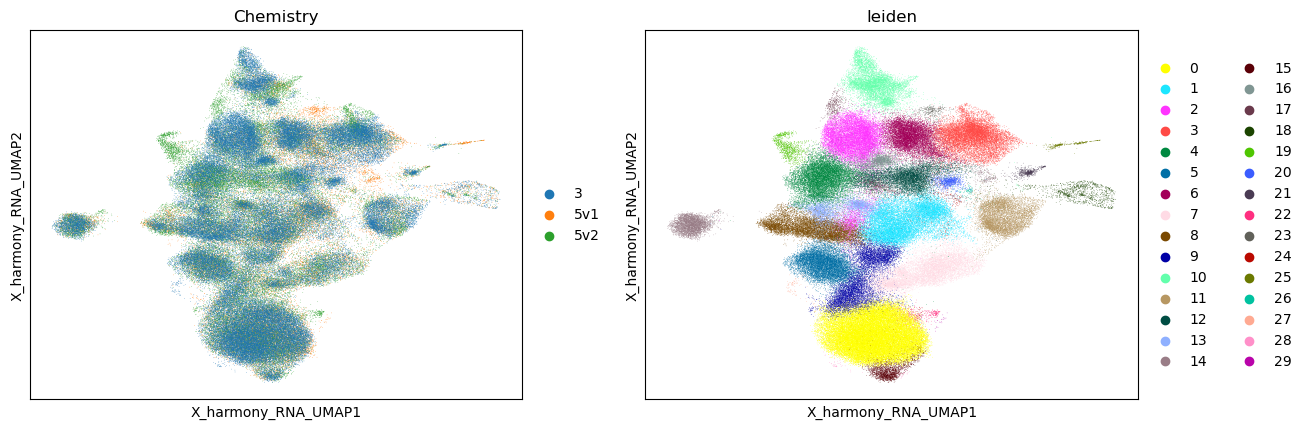

In [29]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= ['Chemistry', 'leiden'])

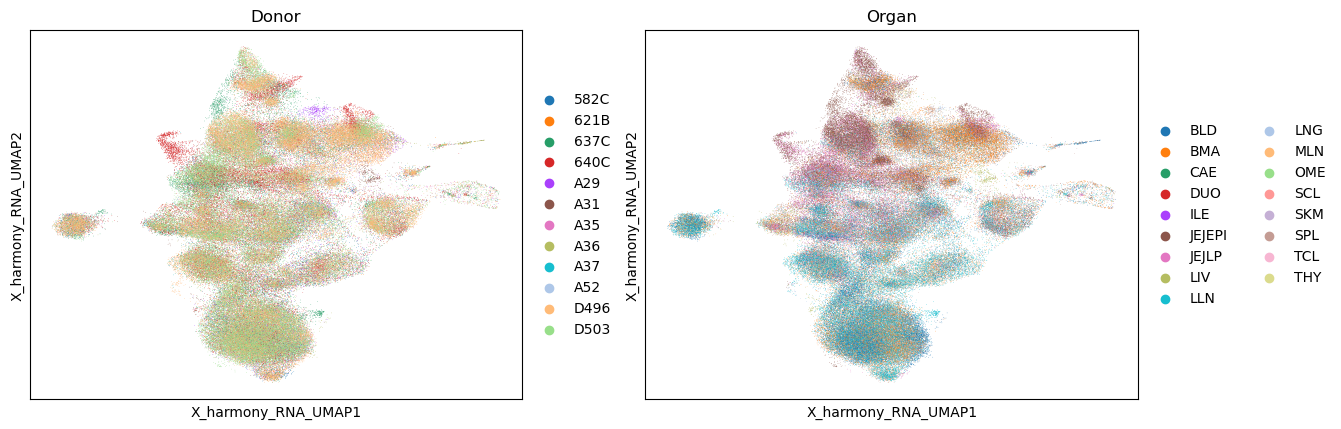

In [30]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= ['Donor', 'Organ'])

In [31]:
paths['RNA_Varnorm_Harmony']

'../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.WithBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [32]:
sc.write(paths['RNA_Varnorm_Harmony'].replace('.h5ad', '.WithUMAP.h5ad'), adata_RNA_c)


Only considering the two last: ['.WithUMAP', '.h5ad'].
Only considering the two last: ['.WithUMAP', '.h5ad'].
